## import libraries

In [1]:
import gym
import torch
import torch.nn as nn
from torch.autograd import Variable
env = gym.make('CartPole-v0')

In [2]:
class PolicyNetwork():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.001):
        self.model = nn.Sequential(
                        nn.Linear(n_state, n_hidden),
                        nn.ReLU(),
                        nn.Linear(n_hidden, n_action),
                        nn.Softmax(),
                        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
    

    def predict(self, s):
      return self.model(torch.Tensor(s))

    def update(self, advantages, log_probs):
      policy_gradient = []
      for log_prob, Gt in zip(log_probs, advantages):
        policy_gradient.append(-log_prob * Gt)
      loss = torch.stack(policy_gradient).sum()
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    def get_action(self, s):
      probs = self.predict(s)
      action = torch.multinomial(probs, 1).item()
      log_prob = torch.log(probs[action])
      return action, log_prob


In [3]:
class ValueNetwork():
  
  def __init__(self, n_state, n_hidden=50, lr=0.05):
    self.criterion = torch.nn.MSELoss()
    self.model = torch.nn.Sequential(
                  torch.nn.Linear(n_state, n_hidden),
                  torch.nn.ReLU(),
                  torch.nn.Linear(n_hidden, 1))
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
  
  def update(self, s, y):
    y_pred = self.model(torch.Tensor(s))
    loss = self.criterion(y_pred,Variable(torch.Tensor(y)))
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def predict(self, s):
    with torch.no_grad():
      return self.model(torch.Tensor(s))

In [4]:
def reinforce(env, estimator_policy, estimator_value,n_episode, gamma=1.0):
  for episode in range(n_episode):
    log_probs = []
    states = []
    rewards = []
    state = env.reset()
    while True:
      states.append(state)
      action, log_prob = estimator_policy.get_action(state)
      next_state, reward, is_done, _ = env.step(action)
      total_reward_episode[episode] += reward
      log_probs.append(log_prob)
      rewards.append(reward)
      if is_done:
        Gt = 0
        pw = 0
        returns = []
        for t in range(len(states)-1, -1, -1):
          Gt += gamma ** pw * rewards[t]
          pw += 1
          returns.append(Gt)
        returns = returns[::-1]
        returns = torch.tensor(returns)
        baseline_values = estimator_value.predict(states)
        advantages = returns - baseline_values
        estimator_value.update(states, returns)
        estimator_policy.update(advantages, log_probs)
        print('Episode: {}, total reward: {}'.format(episode, total_reward_episode[episode]))
        break
      state = next_state

In [5]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden_p = 64
lr_p = 0.003
policy_net = PolicyNetwork(n_state, n_action, n_hidden_p, lr_p)

In [6]:
n_hidden_v = 64
lr_v = 0.003
value_net = ValueNetwork(n_state, n_hidden_v, lr_v)
gamma = 0.9

In [7]:
n_episode = 2000
total_reward_episode = [0] * n_episode
reinforce(env, policy_net, value_net, n_episode, gamma)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size

Episode: 0, total reward: 19.0
Episode: 1, total reward: 38.0
Episode: 2, total reward: 14.0
Episode: 3, total reward: 16.0
Episode: 4, total reward: 14.0
Episode: 5, total reward: 15.0
Episode: 6, total reward: 24.0
Episode: 7, total reward: 16.0
Episode: 8, total reward: 17.0
Episode: 9, total reward: 15.0
Episode: 10, total reward: 12.0
Episode: 11, total reward: 15.0
Episode: 12, total reward: 17.0
Episode: 13, total reward: 27.0
Episode: 14, total reward: 14.0
Episode: 15, total reward: 16.0
Episode: 16, total reward: 21.0
Episode: 17, total reward: 20.0
Episode: 18, total reward: 10.0
Episode: 19, total reward: 13.0
Episode: 20, total reward: 19.0
Episode: 21, total reward: 19.0
Episode: 22, total reward: 17.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Episode: 23, total reward: 26.0
Episode: 24, total reward: 13.0
Episode: 25, total reward: 26.0
Episode: 26, total reward: 13.0
Episode: 27, total reward: 35.0
Episode: 28, total reward: 28.0
Episode: 29, total reward: 46.0
Episode: 30, total reward: 23.0
Episode: 31, total reward: 26.0
Episode: 32, total reward: 26.0
Episode: 33, total reward: 23.0
Episode: 34, total reward: 11.0
Episode: 35, total reward: 18.0
Episode: 36, total reward: 42.0
Episode: 37, total reward: 16.0
Episode: 38, total reward: 31.0
Episode: 39, total reward: 12.0
Episode: 40, total reward: 22.0
Episode: 41, total reward: 29.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([46])) that is different to the input size (torch.Size([46, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Episode: 42, total reward: 15.0
Episode: 43, total reward: 39.0
Episode: 44, total reward: 12.0
Episode: 45, total reward: 21.0
Episode: 46, total reward: 28.0
Episode: 47, total reward: 25.0
Episode: 48, total reward: 20.0
Episode: 49, total reward: 18.0
Episode: 50, total reward: 32.0
Episode: 51, total reward: 13.0
Episode: 52, total reward: 26.0
Episode: 53, total reward: 10.0
Episode: 54, total reward: 37.0
Episode: 55, total reward: 42.0
Episode: 56, total reward: 10.0
Episode: 57, total reward: 17.0
Episode: 58, total reward: 17.0
Episode: 59, total reward: 16.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Episode: 60, total reward: 42.0
Episode: 61, total reward: 21.0
Episode: 62, total reward: 15.0
Episode: 63, total reward: 32.0
Episode: 64, total reward: 20.0
Episode: 65, total reward: 14.0
Episode: 66, total reward: 13.0
Episode: 67, total reward: 41.0
Episode: 68, total reward: 27.0
Episode: 69, total reward: 17.0
Episode: 70, total reward: 24.0
Episode: 71, total reward: 33.0
Episode: 72, total reward: 28.0
Episode: 73, total reward: 24.0
Episode: 74, total reward: 13.0
Episode: 75, total reward: 21.0
Episode: 76, total reward: 33.0
Episode: 77, total reward: 46.0
Episode: 78, total reward: 39.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([41])) that is different to the input size (torch.Size([41, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([33])) that is different to the input size (torch.Size([33, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 79, total reward: 14.0
Episode: 80, total reward: 32.0
Episode: 81, total reward: 32.0
Episode: 82, total reward: 23.0
Episode: 83, total reward: 16.0
Episode: 84, total reward: 30.0
Episode: 85, total reward: 26.0
Episode: 86, total reward: 28.0
Episode: 87, total reward: 52.0
Episode: 88, total reward: 19.0
Episode: 89, total reward: 37.0
Episode: 90, total reward: 20.0
Episode: 91, total reward: 13.0
Episode: 92, total reward: 19.0
Episode: 93, total reward: 43.0
Episode: 94, total reward: 47.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([43])) that is different to the input size (torch.Size([43, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Episode: 95, total reward: 39.0
Episode: 96, total reward: 23.0
Episode: 97, total reward: 32.0
Episode: 98, total reward: 43.0
Episode: 99, total reward: 32.0
Episode: 100, total reward: 15.0
Episode: 101, total reward: 11.0
Episode: 102, total reward: 48.0
Episode: 103, total reward: 38.0
Episode: 104, total reward: 29.0
Episode: 105, total reward: 12.0
Episode: 106, total reward: 16.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([48])) that is different to the input size (torch.Size([48, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([83])) that is different to the input size (torch.Size([83, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 107, total reward: 83.0
Episode: 108, total reward: 16.0
Episode: 109, total reward: 30.0
Episode: 110, total reward: 29.0
Episode: 111, total reward: 41.0
Episode: 112, total reward: 22.0
Episode: 113, total reward: 36.0
Episode: 114, total reward: 30.0
Episode: 115, total reward: 16.0
Episode: 116, total reward: 57.0
Episode: 117, total reward: 21.0
Episode: 118, total reward: 27.0
Episode: 119, total reward: 19.0
Episode: 120, total reward: 30.0
Episode: 121, total reward: 42.0
Episode: 122, total reward: 21.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([57])) that is different to the input size (torch.Size([57, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([91])) that is different to the input size (torch.Size([91, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Episode: 123, total reward: 16.0
Episode: 124, total reward: 91.0
Episode: 125, total reward: 27.0
Episode: 126, total reward: 35.0
Episode: 127, total reward: 23.0
Episode: 128, total reward: 24.0
Episode: 129, total reward: 35.0
Episode: 130, total reward: 49.0
Episode: 131, total reward: 18.0
Episode: 132, total reward: 24.0
Episode: 133, total reward: 41.0
Episode: 134, total reward: 65.0
Episode: 135, total reward: 25.0
Episode: 136, total reward: 18.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([49])) that is different to the input size (torch.Size([49, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([65])) that is different to the input size (torch.Size([65, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([44])) that is different to the input size (torch.Size([44, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Episode: 137, total reward: 20.0
Episode: 138, total reward: 91.0
Episode: 139, total reward: 44.0
Episode: 140, total reward: 21.0
Episode: 141, total reward: 27.0
Episode: 142, total reward: 57.0
Episode: 143, total reward: 52.0
Episode: 144, total reward: 36.0
Episode: 145, total reward: 12.0
Episode: 146, total reward: 39.0
Episode: 147, total reward: 20.0
Episode: 148, total reward: 73.0
Episode: 149, total reward: 29.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([73])) that is different to the input size (torch.Size([73, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([80])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Episode: 150, total reward: 23.0
Episode: 151, total reward: 80.0
Episode: 152, total reward: 19.0
Episode: 153, total reward: 55.0
Episode: 154, total reward: 70.0
Episode: 155, total reward: 61.0
Episode: 156, total reward: 16.0
Episode: 157, total reward: 43.0
Episode: 158, total reward: 15.0
Episode: 159, total reward: 36.0
Episode: 160, total reward: 56.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([56])) that is different to the input size (torch.Size([56, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([58])) that is different to the input size (torch.Size([58, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([34])) that is different to the input size (torch.Size([34, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Episode: 161, total reward: 58.0
Episode: 162, total reward: 65.0
Episode: 163, total reward: 18.0
Episode: 164, total reward: 18.0
Episode: 165, total reward: 34.0
Episode: 166, total reward: 34.0
Episode: 167, total reward: 36.0
Episode: 168, total reward: 18.0
Episode: 169, total reward: 45.0
Episode: 170, total reward: 38.0
Episode: 171, total reward: 67.0
Episode: 172, total reward: 36.0
Episode: 173, total reward: 28.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([67])) that is different to the input size (torch.Size([67, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([53])) that is different to the input size (torch.Size([53, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 174, total reward: 15.0
Episode: 175, total reward: 24.0
Episode: 176, total reward: 28.0
Episode: 177, total reward: 58.0
Episode: 178, total reward: 61.0
Episode: 179, total reward: 25.0
Episode: 180, total reward: 33.0
Episode: 181, total reward: 23.0
Episode: 182, total reward: 80.0
Episode: 183, total reward: 53.0
Episode: 184, total reward: 34.0
Episode: 185, total reward: 47.0
Episode: 186, total reward: 11.0
Episode: 187, total reward: 20.0
Episode: 188, total reward: 12.0
Episode: 189, total reward: 48.0
Episode: 190, total reward: 15.0
Episode: 191, total reward: 113.0
Episode: 192, total reward: 127.0
Episode: 193, total reward: 37.0
Episode: 194, total reward: 76.0
Episode: 195, total reward: 96.0
Episode: 196, total reward: 13.0
Episode: 197, total reward: 56.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([113])) that is different to the input size (torch.Size([113, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([127])) that is different to the input size (torch.Size([127, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([76])) that is different to the input size (torch.Size([76, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input

Episode: 198, total reward: 55.0
Episode: 199, total reward: 103.0
Episode: 200, total reward: 28.0
Episode: 201, total reward: 31.0
Episode: 202, total reward: 34.0
Episode: 203, total reward: 66.0
Episode: 204, total reward: 51.0
Episode: 205, total reward: 59.0
Episode: 206, total reward: 91.0
Episode: 207, total reward: 25.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([103])) that is different to the input size (torch.Size([103, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([66])) that is different to the input size (torch.Size([66, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([51])) that is different to the input size (torch.Size([51, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, 

Episode: 208, total reward: 67.0
Episode: 209, total reward: 42.0
Episode: 210, total reward: 62.0
Episode: 211, total reward: 23.0
Episode: 212, total reward: 59.0
Episode: 213, total reward: 30.0
Episode: 214, total reward: 39.0
Episode: 215, total reward: 34.0
Episode: 216, total reward: 110.0
Episode: 217, total reward: 44.0
Episode: 218, total reward: 33.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([62])) that is different to the input size (torch.Size([62, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([110])) that is different to the input size (torch.Size([110, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 219, total reward: 35.0
Episode: 220, total reward: 38.0
Episode: 221, total reward: 47.0
Episode: 222, total reward: 25.0
Episode: 223, total reward: 94.0
Episode: 224, total reward: 103.0
Episode: 225, total reward: 39.0
Episode: 226, total reward: 45.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([94])) that is different to the input size (torch.Size([94, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([143])) that is different to the input size (torch.Size([143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input

Episode: 227, total reward: 200.0
Episode: 228, total reward: 143.0
Episode: 229, total reward: 64.0
Episode: 230, total reward: 79.0
Episode: 231, total reward: 23.0
Episode: 232, total reward: 98.0
Episode: 233, total reward: 64.0
Episode: 234, total reward: 97.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([79])) that is different to the input size (torch.Size([79, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([98])) that is different to the input size (torch.Size([98, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Episode: 235, total reward: 39.0
Episode: 236, total reward: 44.0
Episode: 237, total reward: 65.0
Episode: 238, total reward: 59.0
Episode: 239, total reward: 18.0
Episode: 240, total reward: 30.0
Episode: 241, total reward: 39.0
Episode: 242, total reward: 88.0
Episode: 243, total reward: 104.0
Episode: 244, total reward: 42.0
Episode: 245, total reward: 63.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([88])) that is different to the input size (torch.Size([88, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([63])) that is different to the input size (torch.Size([63, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, 

Episode: 246, total reward: 42.0
Episode: 247, total reward: 66.0
Episode: 248, total reward: 45.0
Episode: 249, total reward: 24.0
Episode: 250, total reward: 16.0
Episode: 251, total reward: 141.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([141])) that is different to the input size (torch.Size([141, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([86])) that is different to the input size (torch.Size([86, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 252, total reward: 32.0
Episode: 253, total reward: 113.0
Episode: 254, total reward: 86.0
Episode: 255, total reward: 82.0
Episode: 256, total reward: 76.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([82])) that is different to the input size (torch.Size([82, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([68])) that is different to the input size (torch.Size([68, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 257, total reward: 32.0
Episode: 258, total reward: 68.0
Episode: 259, total reward: 149.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([149])) that is different to the input size (torch.Size([149, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([71])) that is different to the input size (torch.Size([71, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 260, total reward: 65.0
Episode: 261, total reward: 71.0
Episode: 262, total reward: 66.0
Episode: 263, total reward: 125.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([125])) that is different to the input size (torch.Size([125, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([95])) that is different to the input size (torch.Size([95, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([117])) that is different to the input size (torch.Size([117, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input

Episode: 264, total reward: 95.0
Episode: 265, total reward: 117.0
Episode: 266, total reward: 25.0
Episode: 267, total reward: 104.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([120])) that is different to the input size (torch.Size([120, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([78])) that is different to the input size (torch.Size([78, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, 

Episode: 268, total reward: 120.0
Episode: 269, total reward: 78.0
Episode: 270, total reward: 92.0
Episode: 271, total reward: 63.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([84])) that is different to the input size (torch.Size([84, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 272, total reward: 84.0
Episode: 273, total reward: 51.0
Episode: 274, total reward: 32.0
Episode: 275, total reward: 41.0
Episode: 276, total reward: 42.0
Episode: 277, total reward: 56.0
Episode: 278, total reward: 44.0
Episode: 279, total reward: 82.0
Episode: 280, total reward: 74.0
Episode: 281, total reward: 99.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([99])) that is different to the input size (torch.Size([99, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 282, total reward: 88.0
Episode: 283, total reward: 114.0
Episode: 284, total reward: 76.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([114])) that is different to the input size (torch.Size([114, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([142])) that is different to the input size (torch.Size([142, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 285, total reward: 142.0
Episode: 286, total reward: 79.0
Episode: 287, total reward: 200.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([72])) that is different to the input size (torch.Size([72, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([109])) that is different to the input size (torch.Size([109, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 288, total reward: 72.0
Episode: 289, total reward: 109.0
Episode: 290, total reward: 34.0
Episode: 291, total reward: 114.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([111])) that is different to the input size (torch.Size([111, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([89])) that is different to the input size (torch.Size([89, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 292, total reward: 111.0
Episode: 293, total reward: 89.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([123])) that is different to the input size (torch.Size([123, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 294, total reward: 93.0
Episode: 295, total reward: 123.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([137])) that is different to the input size (torch.Size([137, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 296, total reward: 137.0
Episode: 297, total reward: 59.0
Episode: 298, total reward: 104.0
Episode: 299, total reward: 141.0
Episode: 300, total reward: 93.0
Episode: 301, total reward: 126.0
Episode: 302, total reward: 99.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([126])) that is different to the input size (torch.Size([126, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 303, total reward: 104.0
Episode: 304, total reward: 142.0
Episode: 305, total reward: 36.0
Episode: 306, total reward: 110.0
Episode: 307, total reward: 111.0
Episode: 308, total reward: 104.0
Episode: 309, total reward: 147.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([147])) that is different to the input size (torch.Size([147, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([156])) that is different to the input size (torch.Size([156, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 310, total reward: 156.0
Episode: 311, total reward: 102.0
Episode: 312, total reward: 33.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([102])) that is different to the input size (torch.Size([102, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([140])) that is different to the input size (torch.Size([140, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 313, total reward: 140.0
Episode: 314, total reward: 158.0
Episode: 315, total reward: 26.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([158])) that is different to the input size (torch.Size([158, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([163])) that is different to the input size (torch.Size([163, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 316, total reward: 163.0
Episode: 317, total reward: 197.0
Episode: 318, total reward: 88.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([197])) that is different to the input size (torch.Size([197, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([132])) that is different to the input size (torch.Size([132, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 319, total reward: 132.0
Episode: 320, total reward: 118.0
Episode: 321, total reward: 54.0
Episode: 322, total reward: 61.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([118])) that is different to the input size (torch.Size([118, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([54])) that is different to the input size (torch.Size([54, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 323, total reward: 120.0
Episode: 324, total reward: 164.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([164])) that is different to the input size (torch.Size([164, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([122])) that is different to the input size (torch.Size([122, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([124])) that is different to the input size (torch.Size([124, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inp

Episode: 325, total reward: 122.0
Episode: 326, total reward: 124.0
Episode: 327, total reward: 116.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([145])) that is different to the input size (torch.Size([145, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([159])) that is different to the input size (torch.Size([159, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inp

Episode: 328, total reward: 145.0
Episode: 329, total reward: 159.0
Episode: 330, total reward: 200.0
Episode: 331, total reward: 141.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([139])) that is different to the input size (torch.Size([139, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([181])) that is different to the input size (torch.Size([181, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 332, total reward: 139.0
Episode: 333, total reward: 83.0
Episode: 334, total reward: 181.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([151])) that is different to the input size (torch.Size([151, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([101])) that is different to the input size (torch.Size([101, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 335, total reward: 151.0
Episode: 336, total reward: 42.0
Episode: 337, total reward: 101.0
Episode: 338, total reward: 200.0
Episode: 339, total reward: 141.0
Episode: 340, total reward: 123.0
Episode: 341, total reward: 140.0
Episode: 342, total reward: 181.0
Episode: 343, total reward: 163.0
Episode: 344, total reward: 126.0
Episode: 345, total reward: 200.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([191])) that is different to the input size (torch.Size([191, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 346, total reward: 191.0
Episode: 347, total reward: 110.0
Episode: 348, total reward: 147.0
Episode: 349, total reward: 173.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([173])) that is different to the input size (torch.Size([173, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 350, total reward: 122.0
Episode: 351, total reward: 133.0
Episode: 352, total reward: 113.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([133])) that is different to the input size (torch.Size([133, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 353, total reward: 200.0
Episode: 354, total reward: 183.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([183])) that is different to the input size (torch.Size([183, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([77])) that is different to the input size (torch.Size([77, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 355, total reward: 77.0
Episode: 356, total reward: 112.0
Episode: 357, total reward: 73.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([112])) that is different to the input size (torch.Size([112, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 358, total reward: 66.0
Episode: 359, total reward: 200.0
Episode: 360, total reward: 41.0
Episode: 361, total reward: 111.0
Episode: 362, total reward: 109.0
Episode: 363, total reward: 167.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([167])) that is different to the input size (torch.Size([167, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 364, total reward: 163.0
Episode: 365, total reward: 141.0
Episode: 366, total reward: 36.0
Episode: 367, total reward: 118.0
Episode: 368, total reward: 175.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([175])) that is different to the input size (torch.Size([175, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([115])) that is different to the input size (torch.Size([115, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 369, total reward: 115.0
Episode: 370, total reward: 178.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([178])) that is different to the input size (torch.Size([178, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([185])) that is different to the input size (torch.Size([185, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 371, total reward: 185.0
Episode: 372, total reward: 156.0
Episode: 373, total reward: 200.0
Episode: 374, total reward: 185.0
Episode: 375, total reward: 200.0
Episode: 376, total reward: 121.0
Episode: 377, total reward: 125.0
Episode: 378, total reward: 200.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([121])) that is different to the input size (torch.Size([121, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 379, total reward: 147.0
Episode: 380, total reward: 171.0
Episode: 381, total reward: 170.0
Episode: 382, total reward: 146.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([171])) that is different to the input size (torch.Size([171, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([170])) that is different to the input size (torch.Size([170, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([146])) that is different to the input size (torch.Size([146, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inp

Episode: 383, total reward: 200.0
Episode: 384, total reward: 138.0
Episode: 385, total reward: 200.0
Episode: 386, total reward: 132.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([138])) that is different to the input size (torch.Size([138, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 387, total reward: 171.0
Episode: 388, total reward: 162.0
Episode: 389, total reward: 139.0
Episode: 390, total reward: 200.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([162])) that is different to the input size (torch.Size([162, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([177])) that is different to the input size (torch.Size([177, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 391, total reward: 177.0
Episode: 392, total reward: 200.0
Episode: 393, total reward: 126.0
Episode: 394, total reward: 149.0
Episode: 395, total reward: 200.0
Episode: 396, total reward: 125.0
Episode: 397, total reward: 170.0
Episode: 398, total reward: 141.0
Episode: 399, total reward: 200.0
Episode: 400, total reward: 169.0
Episode: 401, total reward: 200.0
Episode: 402, total reward: 69.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([169])) that is different to the input size (torch.Size([169, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([69])) that is different to the input size (torch.Size([69, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([154])) that is different to the input size (torch.Size([154, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input

Episode: 403, total reward: 154.0
Episode: 404, total reward: 121.0
Episode: 405, total reward: 164.0
Episode: 406, total reward: 200.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([136])) that is different to the input size (torch.Size([136, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 407, total reward: 136.0
Episode: 408, total reward: 200.0
Episode: 409, total reward: 120.0
Episode: 410, total reward: 200.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([199])) that is different to the input size (torch.Size([199, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([166])) that is different to the input size (torch.Size([166, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 411, total reward: 199.0
Episode: 412, total reward: 162.0
Episode: 413, total reward: 175.0
Episode: 414, total reward: 166.0
Episode: 415, total reward: 200.0
Episode: 416, total reward: 196.0
Episode: 417, total reward: 200.0
Episode: 418, total reward: 200.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([196])) that is different to the input size (torch.Size([196, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([190])) that is different to the input size (torch.Size([190, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 419, total reward: 190.0
Episode: 420, total reward: 200.0
Episode: 421, total reward: 200.0
Episode: 422, total reward: 200.0
Episode: 423, total reward: 200.0
Episode: 424, total reward: 141.0
Episode: 425, total reward: 187.0
Episode: 426, total reward: 200.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([187])) that is different to the input size (torch.Size([187, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 427, total reward: 151.0
Episode: 428, total reward: 138.0
Episode: 429, total reward: 200.0
Episode: 430, total reward: 200.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([172])) that is different to the input size (torch.Size([172, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 431, total reward: 172.0
Episode: 432, total reward: 197.0
Episode: 433, total reward: 115.0
Episode: 434, total reward: 200.0
Episode: 435, total reward: 125.0
Episode: 436, total reward: 164.0
Episode: 437, total reward: 200.0
Episode: 438, total reward: 193.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([193])) that is different to the input size (torch.Size([193, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([106])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 439, total reward: 124.0
Episode: 440, total reward: 106.0
Episode: 441, total reward: 200.0
Episode: 442, total reward: 106.0
Episode: 443, total reward: 190.0
Episode: 444, total reward: 110.0
Episode: 445, total reward: 112.0
Episode: 446, total reward: 180.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([180])) that is different to the input size (torch.Size([180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([168])) that is different to the input size (torch.Size([168, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 447, total reward: 200.0
Episode: 448, total reward: 168.0
Episode: 449, total reward: 200.0
Episode: 450, total reward: 163.0
Episode: 451, total reward: 172.0
Episode: 452, total reward: 160.0
Episode: 453, total reward: 115.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([160])) that is different to the input size (torch.Size([160, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 454, total reward: 197.0
Episode: 455, total reward: 156.0
Episode: 456, total reward: 132.0
Episode: 457, total reward: 200.0
Episode: 458, total reward: 177.0
Episode: 459, total reward: 200.0
Episode: 460, total reward: 200.0
Episode: 461, total reward: 200.0
Episode: 462, total reward: 112.0
Episode: 463, total reward: 200.0
Episode: 464, total reward: 200.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([157])) that is different to the input size (torch.Size([157, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 465, total reward: 157.0
Episode: 466, total reward: 154.0
Episode: 467, total reward: 200.0
Episode: 468, total reward: 46.0
Episode: 469, total reward: 200.0
Episode: 470, total reward: 168.0
Episode: 471, total reward: 144.0
Episode: 472, total reward: 95.0
Episode: 473, total reward: 159.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([144])) that is different to the input size (torch.Size([144, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 474, total reward: 200.0
Episode: 475, total reward: 134.0
Episode: 476, total reward: 200.0
Episode: 477, total reward: 200.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([134])) that is different to the input size (torch.Size([134, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 478, total reward: 197.0
Episode: 479, total reward: 200.0
Episode: 480, total reward: 200.0
Episode: 481, total reward: 110.0
Episode: 482, total reward: 137.0
Episode: 483, total reward: 200.0
Episode: 484, total reward: 195.0
Episode: 485, total reward: 145.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([195])) that is different to the input size (torch.Size([195, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([176])) that is different to the input size (torch.Size([176, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 486, total reward: 200.0
Episode: 487, total reward: 176.0
Episode: 488, total reward: 58.0
Episode: 489, total reward: 157.0
Episode: 490, total reward: 196.0
Episode: 491, total reward: 200.0
Episode: 492, total reward: 200.0
Episode: 493, total reward: 195.0
Episode: 494, total reward: 155.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([155])) that is different to the input size (torch.Size([155, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 495, total reward: 200.0
Episode: 496, total reward: 200.0
Episode: 497, total reward: 157.0
Episode: 498, total reward: 200.0
Episode: 499, total reward: 175.0
Episode: 500, total reward: 200.0
Episode: 501, total reward: 196.0
Episode: 502, total reward: 200.0
Episode: 503, total reward: 193.0
Episode: 504, total reward: 200.0
Episode: 505, total reward: 165.0
Episode: 506, total reward: 134.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([165])) that is different to the input size (torch.Size([165, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 507, total reward: 200.0
Episode: 508, total reward: 200.0
Episode: 509, total reward: 195.0
Episode: 510, total reward: 200.0
Episode: 511, total reward: 200.0
Episode: 512, total reward: 200.0
Episode: 513, total reward: 200.0
Episode: 514, total reward: 167.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([153])) that is different to the input size (torch.Size([153, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 515, total reward: 153.0
Episode: 516, total reward: 169.0
Episode: 517, total reward: 200.0
Episode: 518, total reward: 200.0
Episode: 519, total reward: 200.0
Episode: 520, total reward: 200.0
Episode: 521, total reward: 200.0
Episode: 522, total reward: 134.0
Episode: 523, total reward: 148.0
Episode: 524, total reward: 194.0
Episode: 525, total reward: 200.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([148])) that is different to the input size (torch.Size([148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([194])) that is different to the input size (torch.Size([194, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 526, total reward: 140.0
Episode: 527, total reward: 150.0
Episode: 528, total reward: 168.0
Episode: 529, total reward: 152.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([152])) that is different to the input size (torch.Size([152, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 530, total reward: 200.0
Episode: 531, total reward: 200.0
Episode: 532, total reward: 175.0
Episode: 533, total reward: 186.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([186])) that is different to the input size (torch.Size([186, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([188])) that is different to the input size (torch.Size([188, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 534, total reward: 200.0
Episode: 535, total reward: 188.0
Episode: 536, total reward: 177.0
Episode: 537, total reward: 195.0
Episode: 538, total reward: 200.0
Episode: 539, total reward: 135.0
Episode: 540, total reward: 200.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([135])) that is different to the input size (torch.Size([135, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([192])) that is different to the input size (torch.Size([192, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 541, total reward: 142.0
Episode: 542, total reward: 192.0
Episode: 543, total reward: 200.0
Episode: 544, total reward: 200.0
Episode: 545, total reward: 200.0
Episode: 546, total reward: 200.0
Episode: 547, total reward: 119.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([119])) that is different to the input size (torch.Size([119, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 548, total reward: 143.0
Episode: 549, total reward: 200.0
Episode: 550, total reward: 200.0
Episode: 551, total reward: 178.0
Episode: 552, total reward: 134.0
Episode: 553, total reward: 200.0
Episode: 554, total reward: 113.0
Episode: 555, total reward: 200.0
Episode: 556, total reward: 200.0
Episode: 557, total reward: 120.0
Episode: 558, total reward: 160.0
Episode: 559, total reward: 200.0
Episode: 560, total reward: 200.0
Episode: 561, total reward: 200.0
Episode: 562, total reward: 200.0
Episode: 563, total reward: 200.0
Episode: 564, total reward: 135.0
Episode: 565, total reward: 200.0
Episode: 566, total reward: 200.0
Episode: 567, total reward: 196.0
Episode: 568, total reward: 200.0
Episode: 569, total reward: 171.0
Episode: 570, total reward: 200.0
Episode: 571, total reward: 134.0
Episode: 572, total reward: 200.0
Episode: 573, total reward: 166.0
Episode: 574, total reward: 200.0
Episode: 575, total reward: 200.0
Episode: 576, total reward: 200.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([198])) that is different to the input size (torch.Size([198, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 577, total reward: 198.0
Episode: 578, total reward: 188.0
Episode: 579, total reward: 200.0
Episode: 580, total reward: 133.0
Episode: 581, total reward: 186.0
Episode: 582, total reward: 200.0
Episode: 583, total reward: 200.0
Episode: 584, total reward: 200.0
Episode: 585, total reward: 200.0
Episode: 586, total reward: 178.0
Episode: 587, total reward: 160.0
Episode: 588, total reward: 200.0
Episode: 589, total reward: 200.0
Episode: 590, total reward: 131.0
Episode: 591, total reward: 200.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([131])) that is different to the input size (torch.Size([131, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 592, total reward: 195.0
Episode: 593, total reward: 200.0
Episode: 594, total reward: 139.0
Episode: 595, total reward: 200.0
Episode: 596, total reward: 200.0
Episode: 597, total reward: 200.0
Episode: 598, total reward: 200.0
Episode: 599, total reward: 136.0
Episode: 600, total reward: 198.0
Episode: 601, total reward: 200.0
Episode: 602, total reward: 200.0
Episode: 603, total reward: 200.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([184])) that is different to the input size (torch.Size([184, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 604, total reward: 184.0
Episode: 605, total reward: 200.0
Episode: 606, total reward: 200.0
Episode: 607, total reward: 159.0
Episode: 608, total reward: 183.0
Episode: 609, total reward: 200.0
Episode: 610, total reward: 200.0
Episode: 611, total reward: 200.0
Episode: 612, total reward: 200.0
Episode: 613, total reward: 200.0
Episode: 614, total reward: 200.0
Episode: 615, total reward: 200.0
Episode: 616, total reward: 189.0
Episode: 617, total reward: 200.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([189])) that is different to the input size (torch.Size([189, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 618, total reward: 200.0
Episode: 619, total reward: 177.0
Episode: 620, total reward: 200.0
Episode: 621, total reward: 174.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([174])) that is different to the input size (torch.Size([174, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 622, total reward: 197.0
Episode: 623, total reward: 185.0
Episode: 624, total reward: 200.0
Episode: 625, total reward: 200.0
Episode: 626, total reward: 200.0
Episode: 627, total reward: 148.0
Episode: 628, total reward: 200.0
Episode: 629, total reward: 200.0
Episode: 630, total reward: 140.0
Episode: 631, total reward: 200.0
Episode: 632, total reward: 200.0
Episode: 633, total reward: 200.0
Episode: 634, total reward: 200.0
Episode: 635, total reward: 173.0
Episode: 636, total reward: 200.0
Episode: 637, total reward: 200.0
Episode: 638, total reward: 200.0
Episode: 639, total reward: 200.0
Episode: 640, total reward: 200.0
Episode: 641, total reward: 200.0
Episode: 642, total reward: 200.0
Episode: 643, total reward: 153.0
Episode: 644, total reward: 200.0
Episode: 645, total reward: 200.0
Episode: 646, total reward: 200.0
Episode: 647, total reward: 200.0
Episode: 648, total reward: 200.0
Episode: 649, total reward: 200.0
Episode: 650, total reward: 200.0
Episode: 651, 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([129])) that is different to the input size (torch.Size([129, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 661, total reward: 200.0
Episode: 662, total reward: 200.0
Episode: 663, total reward: 200.0
Episode: 664, total reward: 200.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([108])) that is different to the input size (torch.Size([108, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 665, total reward: 108.0
Episode: 666, total reward: 200.0
Episode: 667, total reward: 200.0
Episode: 668, total reward: 200.0
Episode: 669, total reward: 200.0
Episode: 670, total reward: 200.0
Episode: 671, total reward: 200.0
Episode: 672, total reward: 200.0
Episode: 673, total reward: 200.0
Episode: 674, total reward: 200.0
Episode: 675, total reward: 200.0
Episode: 676, total reward: 200.0
Episode: 677, total reward: 200.0
Episode: 678, total reward: 200.0
Episode: 679, total reward: 200.0
Episode: 680, total reward: 200.0
Episode: 681, total reward: 200.0
Episode: 682, total reward: 200.0
Episode: 683, total reward: 200.0
Episode: 684, total reward: 200.0
Episode: 685, total reward: 200.0
Episode: 686, total reward: 200.0
Episode: 687, total reward: 200.0
Episode: 688, total reward: 200.0
Episode: 689, total reward: 200.0
Episode: 690, total reward: 200.0
Episode: 691, total reward: 200.0
Episode: 692, total reward: 200.0
Episode: 693, total reward: 200.0
Episode: 694, 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([182])) that is different to the input size (torch.Size([182, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 763, total reward: 200.0
Episode: 764, total reward: 200.0
Episode: 765, total reward: 200.0
Episode: 766, total reward: 200.0
Episode: 767, total reward: 200.0
Episode: 768, total reward: 200.0
Episode: 769, total reward: 200.0
Episode: 770, total reward: 200.0
Episode: 771, total reward: 200.0
Episode: 772, total reward: 200.0
Episode: 773, total reward: 200.0
Episode: 774, total reward: 200.0
Episode: 775, total reward: 200.0
Episode: 776, total reward: 200.0
Episode: 777, total reward: 200.0
Episode: 778, total reward: 200.0
Episode: 779, total reward: 200.0
Episode: 780, total reward: 200.0
Episode: 781, total reward: 200.0
Episode: 782, total reward: 200.0
Episode: 783, total reward: 200.0
Episode: 784, total reward: 200.0
Episode: 785, total reward: 200.0
Episode: 786, total reward: 200.0
Episode: 787, total reward: 200.0
Episode: 788, total reward: 200.0
Episode: 789, total reward: 200.0
Episode: 790, total reward: 200.0
Episode: 791, total reward: 199.0
Episode: 792, 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([179])) that is different to the input size (torch.Size([179, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 854, total reward: 200.0
Episode: 855, total reward: 200.0
Episode: 856, total reward: 200.0
Episode: 857, total reward: 200.0
Episode: 858, total reward: 200.0
Episode: 859, total reward: 200.0
Episode: 860, total reward: 200.0
Episode: 861, total reward: 200.0
Episode: 862, total reward: 200.0
Episode: 863, total reward: 200.0
Episode: 864, total reward: 200.0
Episode: 865, total reward: 200.0
Episode: 866, total reward: 200.0
Episode: 867, total reward: 200.0
Episode: 868, total reward: 200.0
Episode: 869, total reward: 200.0
Episode: 870, total reward: 200.0
Episode: 871, total reward: 200.0
Episode: 872, total reward: 168.0
Episode: 873, total reward: 200.0
Episode: 874, total reward: 200.0
Episode: 875, total reward: 200.0
Episode: 876, total reward: 200.0
Episode: 877, total reward: 200.0
Episode: 878, total reward: 200.0
Episode: 879, total reward: 200.0
Episode: 880, total reward: 200.0
Episode: 881, total reward: 200.0
Episode: 882, total reward: 200.0
Episode: 883, 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([161])) that is different to the input size (torch.Size([161, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 1152, total reward: 200.0
Episode: 1153, total reward: 200.0
Episode: 1154, total reward: 200.0
Episode: 1155, total reward: 200.0
Episode: 1156, total reward: 200.0
Episode: 1157, total reward: 200.0
Episode: 1158, total reward: 200.0
Episode: 1159, total reward: 200.0
Episode: 1160, total reward: 200.0
Episode: 1161, total reward: 200.0
Episode: 1162, total reward: 200.0
Episode: 1163, total reward: 199.0
Episode: 1164, total reward: 200.0
Episode: 1165, total reward: 200.0
Episode: 1166, total reward: 200.0
Episode: 1167, total reward: 200.0
Episode: 1168, total reward: 200.0
Episode: 1169, total reward: 200.0
Episode: 1170, total reward: 200.0
Episode: 1171, total reward: 200.0
Episode: 1172, total reward: 200.0
Episode: 1173, total reward: 200.0
Episode: 1174, total reward: 197.0
Episode: 1175, total reward: 200.0
Episode: 1176, total reward: 200.0
Episode: 1177, total reward: 188.0
Episode: 1178, total reward: 200.0
Episode: 1179, total reward: 200.0
Episode: 1180, total

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 1213, total reward: 128.0
Episode: 1214, total reward: 200.0
Episode: 1215, total reward: 200.0
Episode: 1216, total reward: 200.0
Episode: 1217, total reward: 200.0
Episode: 1218, total reward: 200.0
Episode: 1219, total reward: 200.0
Episode: 1220, total reward: 200.0
Episode: 1221, total reward: 200.0
Episode: 1222, total reward: 200.0
Episode: 1223, total reward: 200.0
Episode: 1224, total reward: 200.0
Episode: 1225, total reward: 200.0
Episode: 1226, total reward: 200.0
Episode: 1227, total reward: 200.0
Episode: 1228, total reward: 200.0
Episode: 1229, total reward: 200.0
Episode: 1230, total reward: 200.0
Episode: 1231, total reward: 200.0
Episode: 1232, total reward: 200.0
Episode: 1233, total reward: 200.0
Episode: 1234, total reward: 200.0
Episode: 1235, total reward: 200.0
Episode: 1236, total reward: 200.0
Episode: 1237, total reward: 163.0
Episode: 1238, total reward: 200.0
Episode: 1239, total reward: 200.0
Episode: 1240, total reward: 200.0
Episode: 1241, total

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([130])) that is different to the input size (torch.Size([130, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 1455, total reward: 130.0
Episode: 1456, total reward: 200.0
Episode: 1457, total reward: 200.0
Episode: 1458, total reward: 200.0
Episode: 1459, total reward: 200.0
Episode: 1460, total reward: 200.0
Episode: 1461, total reward: 174.0
Episode: 1462, total reward: 200.0
Episode: 1463, total reward: 200.0
Episode: 1464, total reward: 200.0
Episode: 1465, total reward: 200.0
Episode: 1466, total reward: 200.0
Episode: 1467, total reward: 200.0
Episode: 1468, total reward: 200.0
Episode: 1469, total reward: 200.0
Episode: 1470, total reward: 200.0
Episode: 1471, total reward: 200.0
Episode: 1472, total reward: 200.0
Episode: 1473, total reward: 200.0
Episode: 1474, total reward: 200.0
Episode: 1475, total reward: 200.0
Episode: 1476, total reward: 200.0
Episode: 1477, total reward: 200.0
Episode: 1478, total reward: 200.0
Episode: 1479, total reward: 200.0
Episode: 1480, total reward: 200.0
Episode: 1481, total reward: 200.0
Episode: 1482, total reward: 200.0
Episode: 1483, total

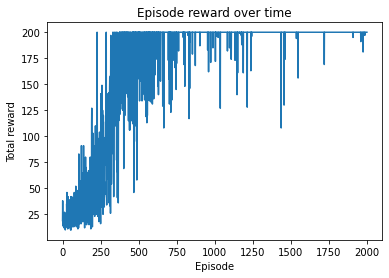

In [8]:
import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()